# Logistic regression
### 1. Preliminaries and problem set-up

In [2]:
%matplotlib inline
import numpy as np
import time
import matplotlib.pyplot as plt

### Logistic regression 
In this exercise session we make our own implementations of some popular optimization methods and test them on the real-world problem of logistic regression. 
More precisely, we tackle problems of the form
$$
    \min_{w \in \mathbb{R}^n} f(w),
$$
where $f:\mathbb{R}^n \mapsto \mathbb{R}$ is given by
$$
    f(w) = \frac{1}{N} \sum_{i=1}^N \log\big(1 + \exp(-y_i(w^\top x_i))\big) + \frac{\mu}{2N}||w||_2^2.
$$

Logistic regression is a supervised machine learning algorithm for binary classification. The data consist of pairs $(x_i, y_i)$ for $i = 1, ..., N$, where the inputs $x_i \in \mathbb{R}^n$ are $n$-dimensional feature vectors, and the outputs $y_i \in \{\pm 1\}$ are binary.

The datasets considered in this exercise session are the a1a dataset, which aims to predict whether a person makes \$50,000 a year based on social features (age, education, gender...), and the colon-cancer dataset, which classifies benign and malignant tumors. 
Let us now import these datasets.

In [2]:
from sklearn.datasets import load_svmlight_file

X_a1a, y_a1a = load_svmlight_file("./datasets/a1a.txt", n_features = 123)
X_a1a = X_a1a.toarray()

X_colon, y_colon = load_svmlight_file("./datasets/colon-cancer.txt", n_features=2000)
X_colon = X_colon.toarray()

print("a1a dataset: N = " + str(X_a1a.shape[0]) + ", n = " + str(X_a1a.shape[1]))
print("colon-cancer dataset: N = " + str(X_colon.shape[0]) + ", n = " + str(X_colon.shape[1]))

a1a dataset: N = 1605, n = 123
colon-cancer dataset: N = 62, n = 2000


### Exercise 1: Regularized logistic regression
Let 
$$
    \sigma_i 
        {}:={}
    \frac{1}{1 + \exp{(-y_i(w^\top x_i))}},
    \qquad
    X 
        {}:={}
    \begin{bmatrix}
        x_1^\top\\
        \vdots\\
        x_N^\top
    \end{bmatrix},
    \qquad
    s
        {}:={}
    \begin{bmatrix}
        y_1(\sigma_1 - 1)\\
        \vdots\\
        y_n(\sigma_n - 1)
    \end{bmatrix}
    \quad \text{and} \quad
    \Sigma
        {}:={}
    \begin{bmatrix}
        \sigma_1(1-\sigma_1) & & \\
        & \ddots & \\
        & & \sigma_N(1 - \sigma_N)
    \end{bmatrix}
$$
Then, the gradient is given by 
$$
    \nabla f(w) = \frac{1}{N} X^\top s + \frac{\mu}{N} w
$$
and the Hessian by
$$
    \nabla^2 f(w) = \frac{1}{N} X^\top \Sigma X + \frac{\mu}{N} I_n.
$$

**Task 1a**: Verify the expressions for the gradient and Hessian of $f$.

**Task 1b**: Is this problem convex? Is it strongly convex? For which values of the parameter $\mu$?

**Task 1c**: Complete the functions below for evaluating $f$, $\nabla f$ and $\nabla^2 f$ at a given point $w$.

**Task 1a**:

$$
    f(w) = \frac{1}{N} \sum_{i=1}^N \log\big(1 + \exp(-y_i(w^\top x_i))\big) + \frac{\mu}{2N}||w||_2^2.
$$

**Task 1b**:

Let $f: S \rarr \mathbb{R}$ be twice differentiable over the open convex set $S \subseteq \mathbb{R}^n$.

- $f$ is convex iff for all $w \in S: \nabla^2 f(w) \geq 0$, i.e. it is positive semi-definite
- $f$ is $\mu$-strongly convex iff for all $w \in S: \nabla^2 f(w) \geq \mu I$
- $f$ is strictly convex iff for all $w \in S: \nabla^2 f(w) > 0$, i.e. it is positive definite

$$
    \nabla^2 f(w) = \frac{1}{N} X^\top \Sigma X + \frac{\mu}{N} I_n.
$$

The matrix $\Sigma$ gives the eigenvalues of the first term: $\sigma_i = \frac{1}{1 + \exp{(-y_i(w^\top x_i))}}$

The more strongly-convex the objective, the faster the optimiser will run. But there is a trade-off: the larger you make the regulariser the less you learn from the data.

In [3]:
def logistic_regression_fun(w, X, y, mu):
    [N, n] = X.shape

    sigma_inv = 1 + np.exp(-y * (X @ w))

    f = (1/N) * np.sum(np.log(sigma_inv)) + (mu/(2*N)) * np.linalg.norm(w)**2

    return f

def logistic_regression_grad(w, X, y, mu):
    [N, n] = X.shape

    sigma = 1 / (1 + np.exp(-y * (X @ w)))

    grad = (1/N) * X.T @ (y * (sigma-1)) + (mu/N) * w

    return grad

def logistic_regression_hess(w, X, y, mu):
    [N, n] = X.shape

    sigma = 1 / (1 + np.exp(-y * (X @ w)))
    Sigma = np.diag(sigma * (1 - sigma))

    hess = (1/N) * X.T @ Sigma @ X + (mu/N) * np.eye(n)

    return hess

### Exercise 2: Gradient descent method
A fundamental algorithm for minimizing a continuously differentiable objective function is the gradient descent method (GD). As the name suggests, a step in the (opposite) direction of the gradient of the objective function is taken at each iteration, with step length given by some stepsize $\eta_k$. In other words, a series of iterates is generated starting from some initial guess $x_0 \in \mathbb{R}^n$, satisfying
\begin{align*}
    d_k {}={}& - \nabla f(w_k)\\
    w_{k+1} {}={}& w_k + \eta_k d_k.
\end{align*}

**Task 2a**: Remark that $\nabla f$ is Lipschitz-continuous with constant $L_f = \frac{1}{4N} \Vert X \Vert^2 + \frac{\mu}{N}$, because $L_f$ is the largest eigenvalue of $\nabla^2 f$. For which values of $\eta$ does gradient descent with fixed stepsize $\eta_k = \eta$ converge according to the theory? What do you observe in practice?

**Task 2b**: Implement the gradient descent method with fixed stepsize $\eta_k = \eta$ by completing the function *gradient_descent*.


**Task 2a**: $0 \leq \eta \leq \frac{2}{L}$

In [4]:
def print_info(w, iter, max_iter):
    if iter == max_iter - 1:
        print('Did not reach the desired tolerance within ' + str(max_iter) + ' outer iterations.')
    else:
        if len(w) <= 2:
            print('Converged to ' + str(w) + ' after ' + str(iter + 1) + ' outer iterations.')
        else:
            print('Converged after ' + str(iter + 1) + ' outer iterations.')

In [5]:
def gradient_descent(f, grad, w0 : np.ndarray, eta : float, tolerance : float, max_iter : int, print_flag = True):
    w = w0
    
    # Evaluate f and gradient
    fw = f(w)
    gradw = grad(w)
    norm_gradw = np.linalg.norm(gradw)

    # Create dictionary for storing history
    hist = {'w':[w],'f':[fw], 'norm_grad':[norm_gradw], 'time':[0]}
    tic = time.perf_counter()

    for iter in range(max_iter):

        ##################################################
        ### TODO: Write your code here
        ##################################################

        # Perform gradient descent step to update x
        w = w + eta * (-gradw)

        # Evaluate f, gradient and gradient norm
        fw = f(w)
        gradw = grad(w)
        norm_gradw = np.linalg.norm(gradw)

        ##################################################

        # Update history
        toc = time.perf_counter()
        hist['w'].append(w)
        hist['f'].append(fw)
        hist['norm_grad'].append(norm_gradw)
        hist['time'].append(toc-tic)

        # Stopping criterion
        if norm_gradw <= tolerance:
            break
    
    if print_flag:
        print_info(w, iter, max_iter)

    hist['w'] = np.array(hist['w'])
    return hist

**Task 2c**: Test the gradient descent method for the following values of the regularization parameter $\mu \in \{0.01, 1, 100\}$. How does the performance scale with the condition number?

In [ ]:
def Lipschitz(X, mu):
    [N, n] = X.shape
    return (1/(4*N))*np.linalg.norm(X,2)**2 + mu/N

def condition_number(X, mu):
    [N, n] = X.shape
    return Lipschitz(X, mu)/(mu/N)

def plot_results(primal_gap_reg, time_points, method_name, fig_num=None, overwrite = False, suptitle = None):
    if overwrite:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), num=fig_num)
        if suptitle is not None:
            fig.suptitle(suptitle)

        ax1.semilogy(primal_gap_reg, label=method_name)
        ax1.set_xlabel('k')
        ax1.set_ylabel(r'$|f(w^k) - f^\star|/|f^\star|$')
        ax1.set_xlim(left=0, right = 500)
        ax1.set_ylim(top = 1e2, bottom = 1e-6)
        ax1.legend()

        ax2.semilogy(time_points, primal_gap_reg, label=method_name)
        ax2.set_xlabel('time [s]')
        ax2.set_ylabel(r'$|f(w^k) - f^\star|/|f^\star|$')
        ax2.set_xlim(left=0, right = 1)
        ax2.set_ylim(top = 1e2, bottom = 1e-6)
        ax2.legend()

    else:
        fig = plt.figure(fig_num)
        (ax1, ax2) = fig.get_axes()

        ax1.semilogy(primal_gap_reg, label=method_name)
        ax1.legend()
        
        ax2.semilogy(time_points, primal_gap_reg, label=method_name)
        ax2.legend()

def get_f_star(dataset, mu):
    if dataset == "a1a":
        if mu == 1:
            f_star = 0.3217095888832289
        elif mu == 0.01:
            f_star = 0.29964738521444695
        elif mu == 100:
            f_star = 0.45060355005189945
        else:
            print("Parameter mu not within range of acceptable values")
    else:
        if mu == 1:
            f_star = 0.016175587061995775
        elif mu == 0.01:
            f_star = 0.0004736141274829741
        elif mu == 100:
            f_star = 0.2314945864242772
        else:
            print("Parameter mu not within range of acceptable values")

    return f_star

def test_dataset_grad_desc(dataset, mu):
    if dataset == "a1a":
        X, y = X_a1a, y_a1a
    elif dataset == "colon":
        X, y = X_colon, y_colon
    else: 
        print("Dataset not supported")

    suptitle = 'regularization = ' + str(mu) +  ', N = ' + str(str(X.shape[0])) + ', n = ' + str(X.shape[1]) + ', condition number \u2248 ' + str(round(condition_number(X, mu)))
    
    w0 = np.zeros(X.shape[1])
    Lf = Lipschitz(X, mu)
    f_star = get_f_star(dataset, mu)
        
    f = lambda w: logistic_regression_fun(w, X, y, mu)
    g = lambda w: logistic_regression_grad(w, X, y, mu)
    h = lambda w: logistic_regression_hess(w, X, y, mu)

    hist_g = gradient_descent(f, g, w0, 1/Lf, 1e-08, 10000, print_flag=False)
    primal_gap_reg = [(f - f_star) / f_star for f in hist_g['f']]

    plot_results(primal_gap_reg, hist_g['time'], 'GD', fig_num = 1, overwrite=True, suptitle=suptitle)

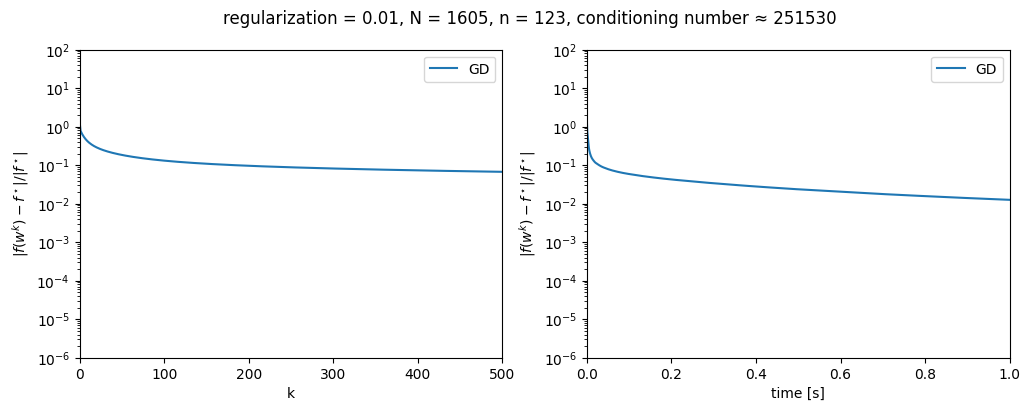

In [7]:
test_dataset_grad_desc("a1a", 0.01)

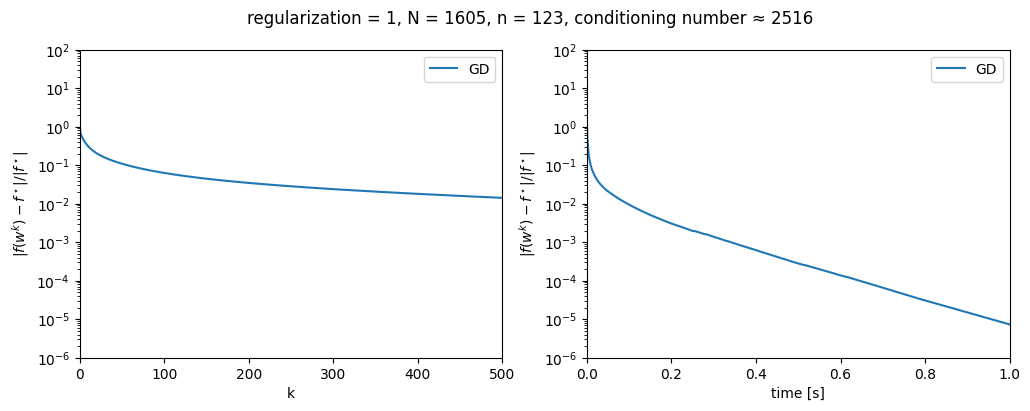

In [8]:
test_dataset_grad_desc("a1a", 1)

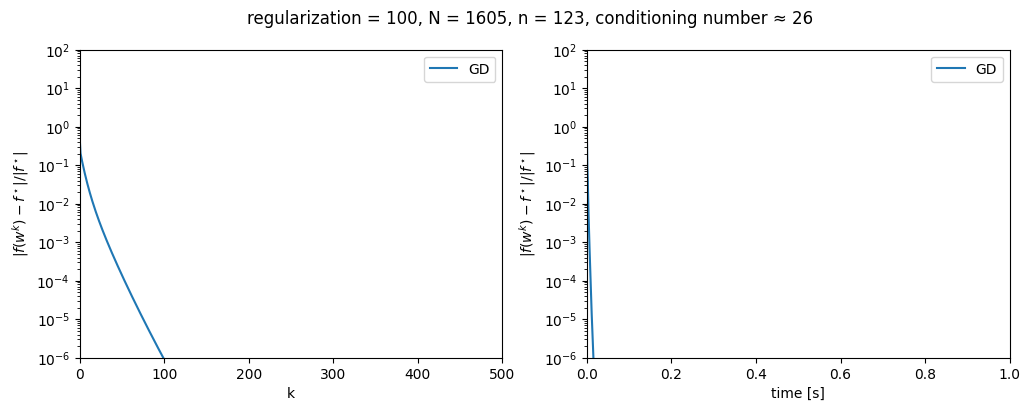

In [9]:
test_dataset_grad_desc("a1a", 100)

### Exercise 3: Gradient descent with Armijo linesearch
One problem with gradient descent is choosing a good stepsize parameter $\eta$. If it is selected too large, the problem may diverge; if it is too small, the problem might take a long time to converge. To alleviate these issues, consider the following procedure abbreviated Armijo GD, which selects a suitable stepsize $\eta$ automatically.

---

**Backtracking linesearch using the Armijo condition**<br>
**Initialize**: $w_k$, $\eta_{init} \in (0, \infty)$, $\beta \in (0, 1)$, $\sigma \in (0, 1)$
1. $\eta_k \leftarrow \eta_{init}$
2. **while** $k < $ max_iter **do** <br>
        $w_{trial} = w_k + \eta_k d_k$ <br>
        **if**  $f(w_{trial}) \leq f(w_k) + \sigma \eta_k \nabla f(w_k)^\top d_k$ **do**<br>
        &emsp; Terminate <br>
        $\eta_k \leftarrow \beta \eta_k$
3. **Return** $w_{trial}$

---

Note that although this method does not require a predefined stepsize $\eta$, it requires more computations per iteration since it employs an inner loop.

**Task 3a**: Implement the backtracking linesearch using the Armijo condition, by completing the function *Armijo_linesearch*.

In [10]:
def Armijo_linesearch(f, search_direction : np.ndarray, w0 : np.ndarray, fw0 : float, directional_derivative_w0 : float, eta_init : float, beta : float, sigma : float):
    max_iter = 1000
    eta = eta_init
    for iter in range(max_iter):

        ##################################################
        ### TODO: Write your code here
        ##################################################

        trial_w = w0 + eta * search_direction
        if f(trial_w) <= fw0 + sigma * eta * directional_derivative_w0:
            break
        eta = beta * eta

        ##################################################
    return trial_w

**Task 3b**: Based on your implementation of the backtracking linesearch from Task 3a, implement a minimizer with linesearch by completing the function *gradient_descent_Armijo*. Use the steepest descent as your step direction as before.

In [16]:
def gradient_descent_Armijo(f, grad, w0 : np.ndarray, eta_init : float, beta : float, sigma : float, tolerance : float, max_iter : int, print = True):
    w = w0

    # Evaluate f and gradient
    fw = f(w)
    gradw = grad(w)
    norm_gradw = np.linalg.norm(gradw)

    # Create dictionary for storing history
    hist = {'w':[w],'f':[fw], 'norm_grad':[norm_gradw], 'time':[0]}
    tic = time.perf_counter()

    for iter in range(max_iter):
        
        ##################################################
        ### TODO: Write your code here
        ##################################################
        
        # Perform gradient descent step with linesearch
        search_direction = -gradw
        directional_derivative_w = gradw.T @ search_direction
        w = Armijo_linesearch(f, search_direction, w, fw, directional_derivative_w, eta_init, beta, sigma)

        # Evaluate f, gradient and gradient norm
        fw = f(w)
        gradw = grad(w)
        norm_gradw = np.linalg.norm(gradw)

        ##################################################

        # Update history
        toc = time.perf_counter()
        hist['w'].append(w)
        hist['f'].append(fw)
        hist['norm_grad'].append(norm_gradw)
        hist['time'].append(toc-tic)

        # Stopping criterion
        if norm_gradw <= tolerance:
            break

    if print:
        print_info(w, iter, max_iter)

    hist['w'] = np.array(hist['w'])
    return hist

**Task 3c**: Test the gradient descent method with linesearch on the logistic regression problem for $\mu \in \{0.01, 1, 100\}$. Compare to gradient descent using a fixed stepsize. What do you observe? Why is this?

In [ ]:
def test_dataset_grad_desc_armijo(dataset, mu, compare_to_previous = True):
    if dataset == "a1a":
        X, y = X_a1a, y_a1a
    elif dataset == "colon":
        X, y = X_colon, y_colon
    else: 
        print("Dataset not supported")

    suptitle = 'regularization = ' + str(mu) +  ', N = ' + str(str(X.shape[0])) + ', n = ' + str(X.shape[1]) + ', condition number \u2248 ' + str(round(condition_number(X, mu)))
    
    w0 = np.zeros(X.shape[1])
    Lf = Lipschitz(X, mu)
    f_star = get_f_star(dataset, mu)    

    f = lambda w: logistic_regression_fun(w, X, y, mu)
    g = lambda w: logistic_regression_grad(w, X, y, mu)
    h = lambda w: logistic_regression_hess(w, X, y, mu)

    if compare_to_previous:
        hist_g_fixed = gradient_descent(f, g, w0, 1/Lf, 1e-08, 10000, print_flag=False)
        primal_gap_reg_fixed = [(f - f_star) / f_star for f in hist_g_fixed['f']]

        hist_g_armijo = gradient_descent_Armijo(f, g, w0, 100/Lf, 0.5, 1e-1, 1e-08, 5000, print=False)
        primal_gap_reg_armijo = [(f - f_star) / f_star for f in hist_g_armijo['f']]

        # Plot results
        plot_results(primal_gap_reg_fixed, hist_g_fixed['time'], 'GD', fig_num=1, overwrite=True, suptitle=suptitle)
        plot_results(primal_gap_reg_armijo, hist_g_armijo['time'], 'Armijo_GD', fig_num=1, overwrite=False)
    else:
        hist_g_armijo = gradient_descent_Armijo(f, g, w0, 100/Lf, 0.5, 1e-1, 1e-08, 5000, print=False)
        primal_gap_reg_armijo = [(f - f_star) / f_star for f in hist_g_armijo['f']]

        # Plot results
        plot_results(primal_gap_reg_armijo, hist_g_armijo['time'], 'Armijo_GD', fig_num=1, overwrite=True, suptitle=suptitle)

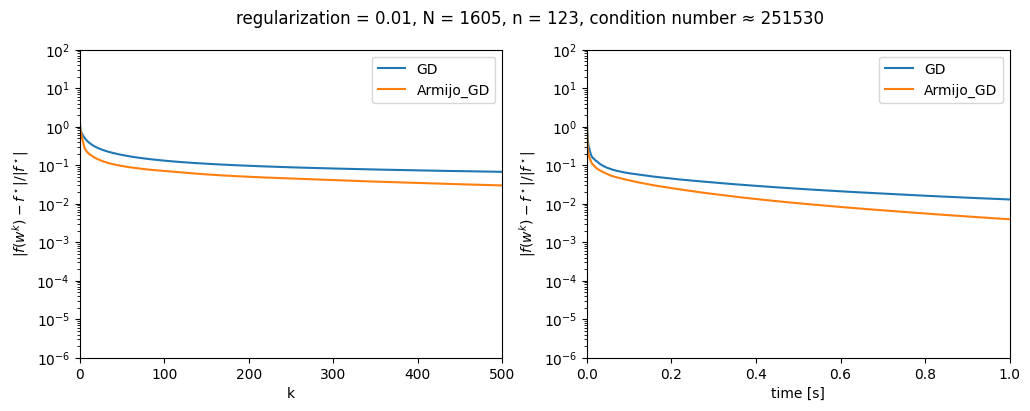

In [18]:
test_dataset_grad_desc_armijo("a1a", 0.01, compare_to_previous=True)

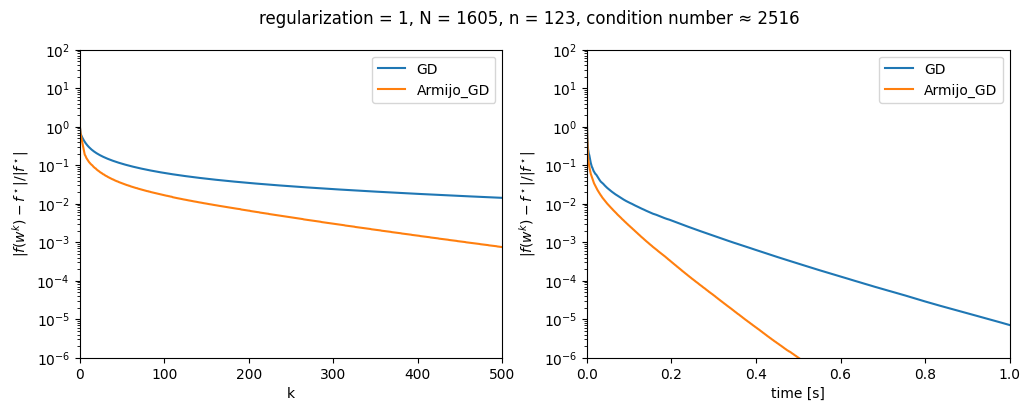

In [19]:
test_dataset_grad_desc_armijo("a1a", 1, compare_to_previous=True)

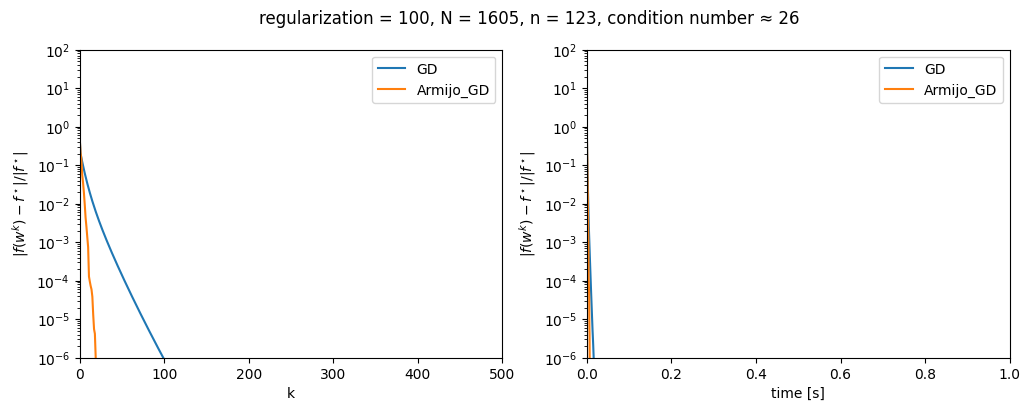

In [20]:
test_dataset_grad_desc_armijo("a1a", 100, compare_to_previous=True)

### Exercise 4: Accelerated gradient descent
Although standard gradient descent is a reliable method that tackles smooth optimization problems, often in practice it can be quite slow. In the case where the cost function is convex, one way to **accelerate** its convergence is through the use of momentum, utilizing information from the previous iterates. 

One of the most effective accelerated algorithms is Nesterov's accelerated gradient descent (NAG), which in its simplest form comprises of the following steps
\begin{align*}
    z_k &= w_k + \tfrac{k}{k+3}(w_k - w_{k-1})\\
    w_{k+1} &= z_k - \eta_k \nabla f(z_k).
\end{align*}

**Task 4a**: Implement NAG by completing the code in *accelerated_gradient_descent*.

In [26]:
def accelerated_gradient_descent(f, grad, w0 : np.ndarray, eta : float, tolerance : float, max_iter : int, print_flag = True):
    w = np.copy(w0)
    w_prev = np.copy(w0)
    
    # Evaluate f and gradient
    fw = f(w)
    gradw = grad(w)
    gradz = np.copy(gradw)
    norm_gradw = np.linalg.norm(gradw)

    # Create dictionary for storing history
    hist = {'w':[w],'f':[fw], 'norm_grad':[norm_gradw], 'time':[0]}
    tic = time.perf_counter()

    for iter in range(max_iter):
        
        ##################################################
        ### TODO: Write your code here
        ##################################################

        # Perform gradient descent step to update w
        z = w + (iter/(iter+3))*(w - w_prev)
        gradz = grad(z)
        w_prev = np.copy(w)
        w = z - eta * gradz

        # Evaluate f, gradient and gradient norm
        fw = f(w)
        gradw = grad(w)
        norm_gradw = np.linalg.norm(gradw)

        ##################################################

        # Update history
        toc = time.perf_counter()
        hist['w'].append(w)
        hist['f'].append(fw)
        hist['norm_grad'].append(norm_gradw)
        hist['time'].append(toc-tic)

        # Stopping criterion
        if norm_gradw <= tolerance:
            break
    
    if print_flag:
        print_info(w, iter, max_iter)

    hist['w'] = np.array(hist['w'])
    return hist

**Task 4b**: Test the accelerated gradient descent method on the logistic regression problem for $\mu \in \{0.01, 1, 100\}$. What do you observe? Is this still a descent method?

In [ ]:
def test_dataset_acc_grad_desc(dataset, mu, compare_to_previous = True):
    if dataset == "a1a":
        X, y = X_a1a, y_a1a
    elif dataset == "colon":
        X, y = X_colon, y_colon
    else: 
        print("Dataset not supported")

    suptitle = 'regularization = ' + str(mu) +  ', N = ' + str(str(X.shape[0])) + ', n = ' + str(X.shape[1]) + ', condition number \u2248 ' + str(round(condition_number(X, mu)))
    
    w0 = np.zeros(X.shape[1])
    Lf = Lipschitz(X, mu)
    f_star = get_f_star(dataset, mu)

    f = lambda w: logistic_regression_fun(w, X, y, mu)
    g = lambda w: logistic_regression_grad(w, X, y, mu)
    h = lambda w: logistic_regression_hess(w, X, y, mu)

    if compare_to_previous:
        hist_g_fixed = gradient_descent(f, g, w0, 1/Lf, 1e-08, 10000, print_flag=False)
        primal_gap_reg_fixed = [(f - f_star) / f_star for f in hist_g_fixed['f']]

        hist_g_armijo = gradient_descent_Armijo(f, g, w0, 100/Lf, 0.5, 1e-1, 1e-08, 5000, print=False)
        primal_gap_reg_armijo = [(f - f_star) / f_star for f in hist_g_armijo['f']]

        hist_g_nag = accelerated_gradient_descent(f, g, w0, 1/Lf, 1e-08, 10000, print_flag=False)
        primal_gap_reg_nag = [(f - f_star) / f_star for f in hist_g_nag['f']]

        # Plot results
        plot_results(primal_gap_reg_fixed, hist_g_fixed['time'], 'GD', fig_num=1, overwrite=True, suptitle=suptitle)
        plot_results(primal_gap_reg_armijo, hist_g_armijo['time'], 'Armijo_GD', fig_num=1, overwrite=False)
        plot_results(primal_gap_reg_nag, hist_g_nag['time'], 'NAG', fig_num=1, overwrite=False)
    else:
        hist_g_nag = accelerated_gradient_descent(f, g, w0, 1/Lf, 1e-08, 10000, print_flag=False)
        primal_gap_reg_nag = [(f - f_star) / f_star for f in hist_g_nag['f']]

        # Plot results
        plot_results(primal_gap_reg_nag, hist_g_nag['time'], 'NAG', fig_num=1, overwrite=True, suptitle=suptitle)

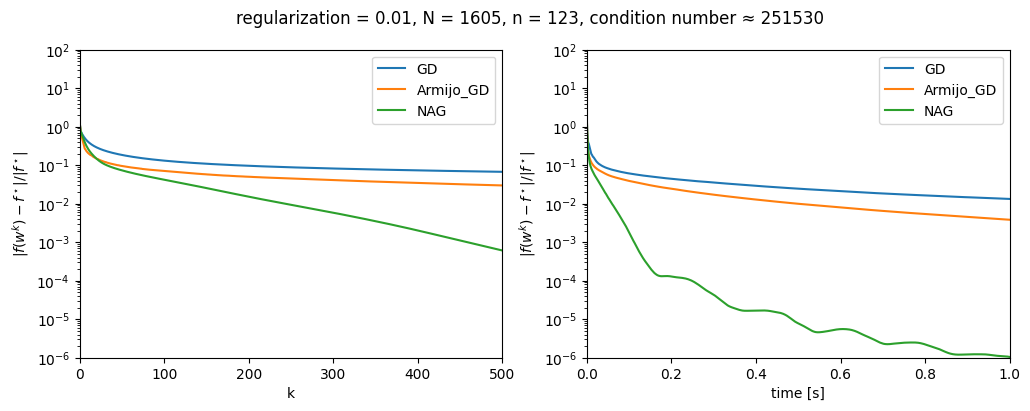

In [28]:
test_dataset_acc_grad_desc("a1a", 0.01, compare_to_previous=True)

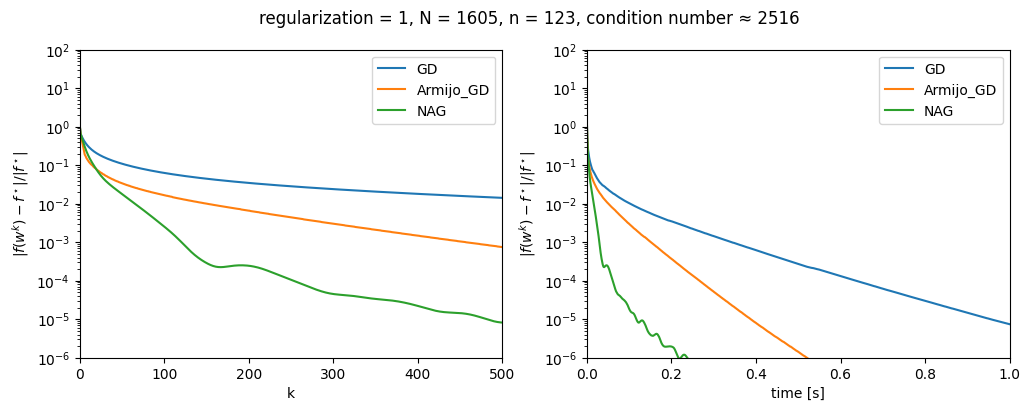

In [29]:
test_dataset_acc_grad_desc("a1a", 1, compare_to_previous=True)

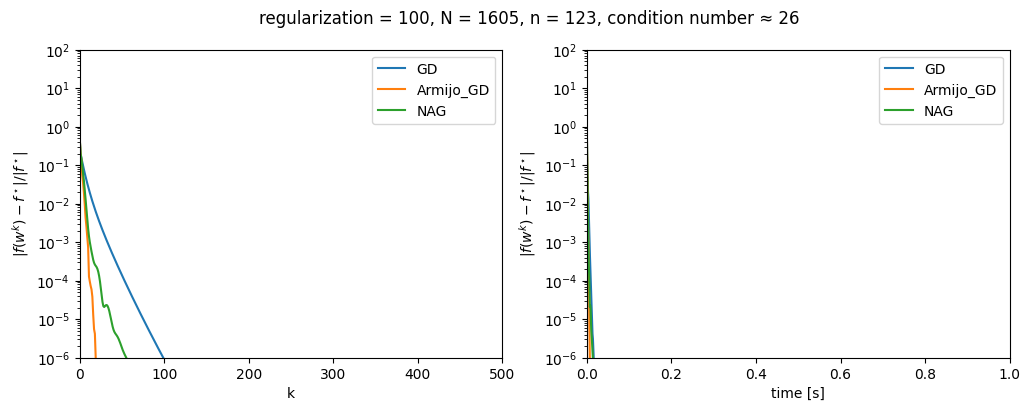

In [30]:
test_dataset_acc_grad_desc("a1a", 100, compare_to_previous=True)

**Note**: The accelerated implementation does not always decrease. This is normal.

In the case where $f$ is a strongly convex function a different version of the accelerated gradient method can be implemented. It has the following form:
\begin{align*}
    z_k &= w_k + \tfrac{\sqrt{\kappa}-1}{\sqrt{\kappa}+1}(w_k - w_{k-1})\\
    w_{k+1} &= z_k - \eta_k \nabla f(z_k),
\end{align*}
where $\kappa$ is the condition number. 

**Task 4.c** Implement the strongly convex version of the accelerated gradient descent method (scAGD) by completing the code in *sc_accelerated_gradient_descent*.

In [ ]:
def sc_accelerated_gradient_descent(f, grad, X, mu, w0 : np.ndarray, eta : float, tolerance : float, max_iter : int, print_flag = True):
    w = np.copy(w0)
    w_prev = np.copy(w0)
    # Compute parameter beta
    beta = (np.sqrt(condition_number(X, mu)) - 1) / (np.sqrt(condition_number(X, mu)) + 1)
    
    # Evaluate f and gradient
    fw = f(w)
    gradw = grad(w)
    gradz = np.copy(gradw)
    norm_gradw = np.linalg.norm(gradw)

    # Create dictionary for storing history
    hist = {'w':[w],'f':[fw], 'norm_grad':[norm_gradw], 'time':[0]}
    tic = time.perf_counter()

    for iter in range(max_iter):
        
        ##################################################
        ### TODO: Write your code here
        ##################################################

        # Perform gradient descent step to update w
        z = w + beta * (w - w_prev)
        gradz = grad(z)
        w_prev = np.copy(w)
        w = z - eta * gradz

        # Evaluate f, gradient and gradient norm
        fw = f(w)
        gradw = grad(w)
        norm_gradw = np.linalg.norm(gradw)

        ##################################################

        # Update history
        toc = time.perf_counter()
        hist['w'].append(w)
        hist['f'].append(fw)
        hist['norm_grad'].append(norm_gradw)
        hist['time'].append(toc-tic)

        # Stopping criterion
        if norm_gradw <= tolerance:
            break
    
    if print_flag:
        print_info(w, iter, max_iter)

    hist['w'] = np.array(hist['w'])
    return hist

**Task 4d**: Test the strongly convex accelerated gradient descent method on the logistic regression problem for $\mu \in \{0.01, 1, 100\}$. Compare with the performance of NAG. What do you observe? Is this a descent method?

In [ ]:
def test_dataset_sc_acc_grad_desc(dataset, mu, compare_to_previous = True):
    if dataset == "a1a":
        X, y = X_a1a, y_a1a
    elif dataset == "colon":
        X, y = X_colon, y_colon
    else: 
        print("Dataset not supported")

    suptitle = 'regularization = ' + str(mu) +  ', N = ' + str(str(X.shape[0])) + ', n = ' + str(X.shape[1]) + ', condition number \u2248 ' + str(round(condition_number(X, mu)))
    
    w0 = np.zeros(X.shape[1])
    Lf = Lipschitz(X, mu)
    f_star = get_f_star(dataset, mu)

    f = lambda w: logistic_regression_fun(w, X, y, mu)
    g = lambda w: logistic_regression_grad(w, X, y, mu)
    h = lambda w: logistic_regression_hess(w, X, y, mu)

    if compare_to_previous:
        hist_g_fixed = gradient_descent(f, g, w0, 1/Lf, 1e-08, 10000, print_flag=False)
        primal_gap_reg_fixed = [(f - f_star) / f_star for f in hist_g_fixed['f']]

        hist_g_armijo = gradient_descent_Armijo(f, g, w0, 100/Lf, 0.5, 1e-1, 1e-08, 5000, print=False)
        primal_gap_reg_armijo = [(f - f_star) / f_star for f in hist_g_armijo['f']]

        hist_g_nag = accelerated_gradient_descent(f, g, w0, 1/Lf, 1e-08, 10000, print_flag=False)
        primal_gap_reg_nag = [(f - f_star) / f_star for f in hist_g_nag['f']]

        hist_g_scAGD = sc_accelerated_gradient_descent(f, g, X, mu, w0, 1/Lf, 1e-08, 10000, print_flag=False)
        primal_gap_reg_scAGD = [(f - f_star) / f_star for f in hist_g_scAGD['f']]

        # Plot results
        plot_results(primal_gap_reg_fixed, hist_g_fixed['time'], 'GD', fig_num=1, overwrite=True, suptitle=suptitle)
        plot_results(primal_gap_reg_armijo, hist_g_armijo['time'], 'Armijo_GD', fig_num=1, overwrite=False)
        plot_results(primal_gap_reg_nag, hist_g_nag['time'], 'NAG', fig_num=1, overwrite=False)
        plot_results(primal_gap_reg_scAGD, hist_g_scAGD['time'], 'scAGD', fig_num=1, overwrite=False)
    else:
        hist_g_scAGD = sc_accelerated_gradient_descent(f, g, X, mu, w0, 1/Lf, 1e-08, 10000, print_flag=False)
        primal_gap_reg_scAGD = [(f - f_star) / f_star for f in hist_g_scAGD['f']]

        # Plot results
        plot_results(primal_gap_reg_scAGD, hist_g_scAGD['time'], 'scAGD', fig_num=1, overwrite=True, suptitle=suptitle)

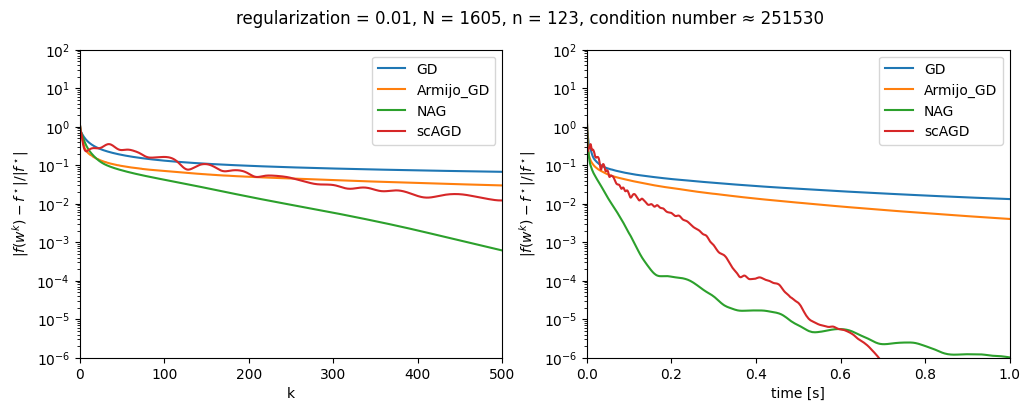

In [33]:
test_dataset_sc_acc_grad_desc("a1a", 0.01, compare_to_previous=True)

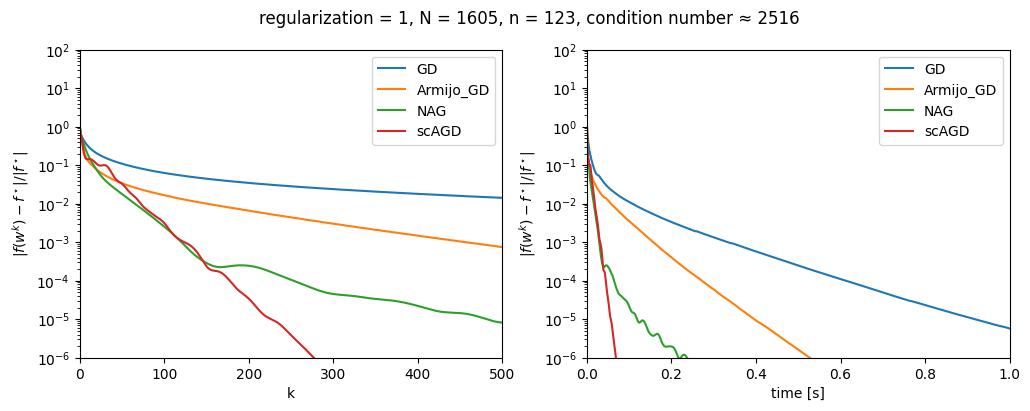

In [34]:
test_dataset_sc_acc_grad_desc("a1a", 1, compare_to_previous=True)

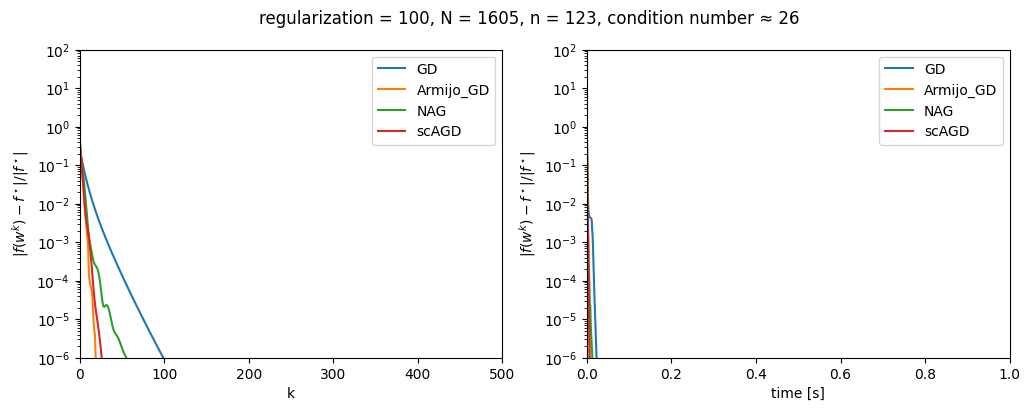

In [35]:
test_dataset_sc_acc_grad_desc("a1a", 100, compare_to_previous=True)

### Exercise 5: Exact Newton's method
In numerical analysis, Newton's method is a method for finding roots of equations in one or multiple dimensions. In the context of optimization, this method can be used to find a stationary point of our objective function, i.e., finding a point $w^\star$ such that
$$
    \nabla f(w^\star) = 0,
$$
where $\nabla f : \mathbb{R}^n \rightarrow \mathbb{R}^n$.

The main idea behind Newton's method is to linearize $\nabla f$ at the current iterate $w_k$ and solve a simplified linear system of equations to obtain the new iterate $w_{k+1} = w_k + d_k$. More specifically, the linearized system is given by
\begin{align*}
    \nabla f(w_k) + \nabla^2 f(w_k) d_k = 0.
\end{align*}
Consequently, the Newton step is equal to
$$
    d_k = -(\nabla^2 f(w_k))^{-1}\nabla f(w_k),
$$
where it is implicitly assumed that $\nabla^2 f(w_k)$ is nonsingular.

**Task 5a**: Based on your implementation of the backtracking linesearch from Task 2a, implement Newton's method with linesearch by completing the function *newton*. Use the Newton step as your step direction.

In [ ]:
def newton(f, grad, hess, w0 : np.ndarray, tolerance : float, max_iter : int, print = True):
    w = w0

    # Evaluate f, gradient and Hessian
    fw= f(w)
    gradw = grad(w)
    hessw= hess(w)
    norm_gradw = np.linalg.norm(gradw)

    # Create dictionary for storing history
    hist = {'w':[w],'f':[fw], 'norm_grad':[norm_gradw], 'time':[0]}
    tic = time.perf_counter()

    for iter in range(max_iter):

        ##################################################
        ### TODO: Write your code here
        ##################################################

        # Perform Newton step and linesearch
        search_direction = np.linalg.solve(hessw, -gradw)
        directional_derivative = gradw.T @ search_direction
        w = Armijo_linesearch(f, search_direction, w, fw, directional_derivative, 1, 0.8, 1e-1)

        # Evaluate f, gradient, gradient norm and Hessian
        fw = f(w)
        gradw = grad(w)
        hessw = hess(w)
        norm_gradw = np.linalg.norm(gradw)

        ##################################################

        # Update history
        toc = time.perf_counter()
        hist['w'].append(w)
        hist['f'].append(fw)
        hist['norm_grad'].append(norm_gradw)
        hist['time'].append(toc-tic)

        # Stopping criterion
        if norm_gradw <= tolerance:
            break

    if print:
        print_info(w, iter, max_iter)
        
    hist['w'] = np.array(hist['w'])
    return hist

**Task 5b**: Test Newton's method with linesearch on the logistic regression problem. Compare the results with the methods tested previously. What do you observe regarding the required number of iterations and total time? Look at the impact of both the condition number and the problem dimensions $n, N$.

In [ ]:
def test_dataset_newton(dataset, mu, compare_to_previous = True):
    if dataset == "a1a":
        X, y = X_a1a, y_a1a
    elif dataset == "colon":
        X, y = X_colon, y_colon
    else: 
        print("Dataset not supported")

    suptitle = 'regularization = ' + str(mu) +  ', N = ' + str(str(X.shape[0])) + ', n = ' + str(X.shape[1]) + ', condition number \u2248 ' + str(round(condition_number(X, mu)))
    
    w0 = np.zeros(X.shape[1])
    Lf = Lipschitz(X, mu)
    f_star = get_f_star(dataset, mu)

    f = lambda w: logistic_regression_fun(w, X, y, mu)
    g = lambda w: logistic_regression_grad(w, X, y, mu)
    h = lambda w: logistic_regression_hess(w, X, y, mu)

    if compare_to_previous:
        hist_g_fixed = gradient_descent(f, g, w0, 1/Lf, 1e-08, 10000, print_flag=False)
        primal_gap_reg_fixed = [(f - f_star) / f_star for f in hist_g_fixed['f']]

        hist_g_armijo = gradient_descent_Armijo(f, g, w0, 100/Lf, 0.5, 1e-1, 1e-08, 5000, print=False)
        primal_gap_reg_armijo = [(f - f_star) / f_star for f in hist_g_armijo['f']]

        hist_g_nag = accelerated_gradient_descent(f, g, w0, 1/Lf, 1e-08, 10000, print_flag=False)
        primal_gap_reg_nag = [(f - f_star) / f_star for f in hist_g_nag['f']]

        hist_g_scAGD = sc_accelerated_gradient_descent(f, g, X, mu, w0, 1/Lf, 1e-08, 10000, print_flag=False)
        primal_gap_reg_scAGD = [(f - f_star) / f_star for f in hist_g_scAGD['f']]

        hist_n = newton(f, g, h, w0, 1e-08, 100, print=False)
        primal_gap_reg_n = [(f - f_star) / f_star for f in hist_n['f']]

        # Plot results
        plot_results(primal_gap_reg_fixed, hist_g_fixed['time'], 'GD', fig_num=1, overwrite=True, suptitle=suptitle)
        plot_results(primal_gap_reg_armijo, hist_g_armijo['time'], 'Armijo_GD', fig_num=1, overwrite=False)
        plot_results(primal_gap_reg_nag, hist_g_nag['time'], 'NAG', fig_num=1, overwrite=False)
        plot_results(primal_gap_reg_scAGD, hist_g_scAGD['time'], 'scAGD', fig_num=1, overwrite=False)
        plot_results(primal_gap_reg_n, hist_n['time'], 'Newton', fig_num=1, overwrite=False)
    else:
        hist_n = newton(f, g, h, w0, 1e-08, 100, print=False)
        primal_gap_reg_n = [(f - f_star) / f_star for f in hist_n['f']]
    
        # Plot results
        plot_results(primal_gap_reg_n, hist_n['time'], 'Newton', fig_num=1, overwrite=True, suptitle=suptitle)

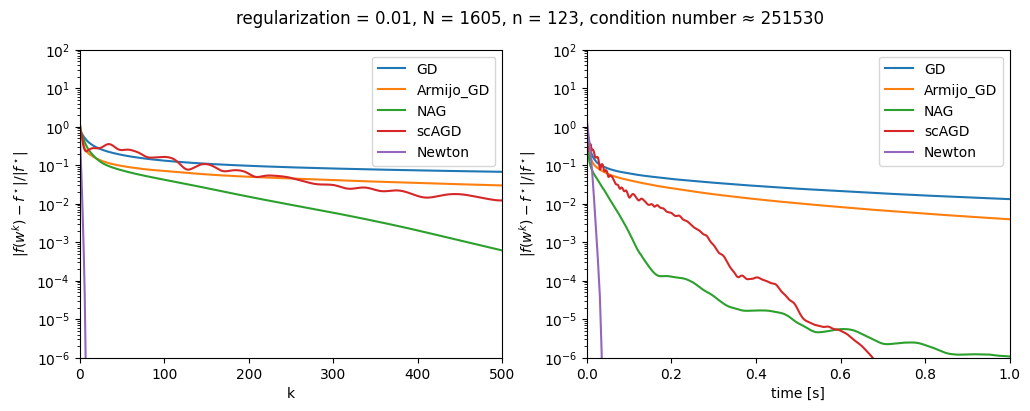

In [38]:
test_dataset_newton("a1a", 0.01, compare_to_previous=True)

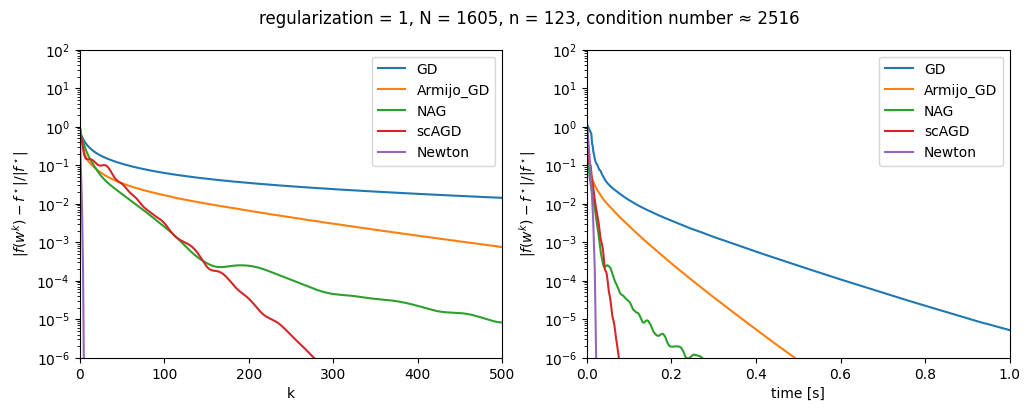

In [39]:
test_dataset_newton("a1a", 1, compare_to_previous=True)

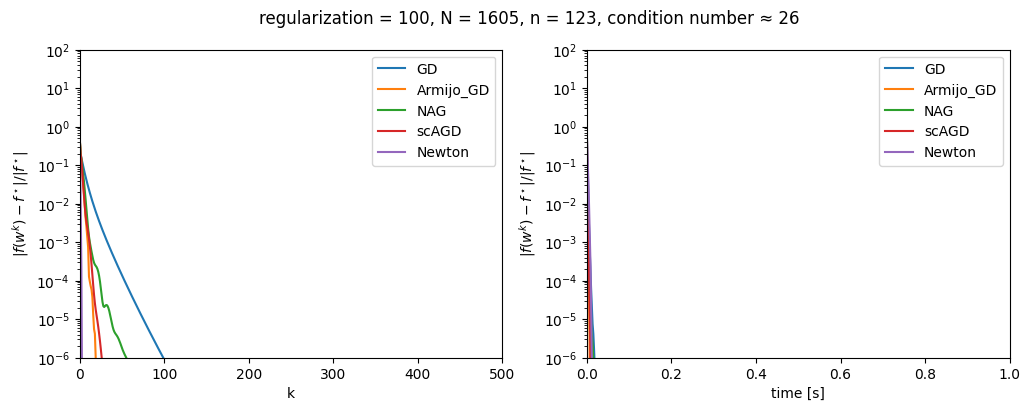

In [40]:
test_dataset_newton("a1a", 100, compare_to_previous=True)

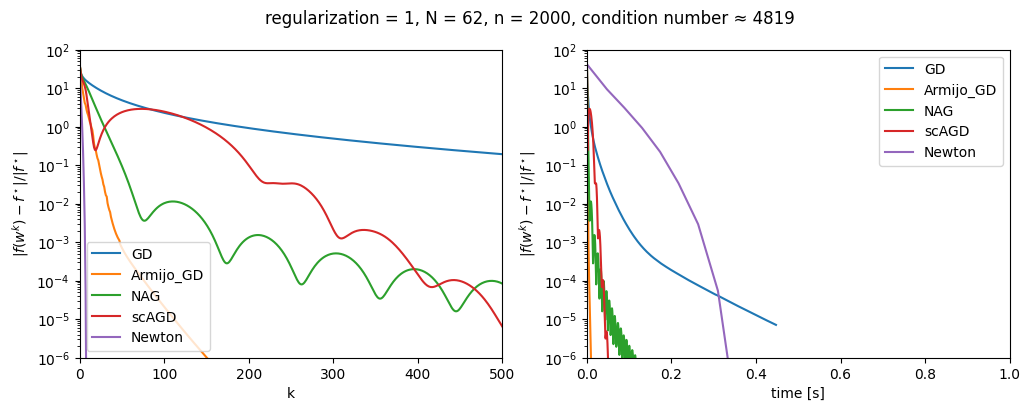

In [41]:
test_dataset_newton("colon", 1, compare_to_previous=True)

**Note**: Newton's method is not faster (in terms of time) for both datasets. It is always faster in terms of iterations. The second dataset has fewer samples than the feature size.

### Exercise 6: BFGS

There are several major issues with Newton's method. Most notably, the Hessian $\nabla^2 f$ might be
- difficult to compute analytically
- not invertible
- not be positive definite (in which case the Newton step is not a direction of descent)

The goal of quasi-Newton methods is to use Newton-type steps while alleviating most of these issues. In particular, these algorithms generate an approximation of the Hessian $B_k$. One algorithm for updating the approximate Hessian $B_k$ is the famous BFGS (Broyden-Fletcher-Goldfarb-Shanno) formula. This formula updates $B_k$ based on the secant condition using only rank-two modifications and is given by
\begin{equation}\tag{5.1}
  B_{k+1} =  B_{k} + \frac{p_kp_k^\top}{p_k^\top s_k} - \frac{B_k s_ks_k^\top B_k}{s_k^\top B_k s_k} 
\end{equation}
with $s_k$ and $p_k$ defined as:
\begin{align}
  s_k  
    {}={}&
  w_{k+1} -  w_{k}, \tag{5.2a}
  \\%
  p_k  
    {}={}&
  \nabla f(w_{k+1}) - \nabla f(w_{k}).\tag{5.2b}
\end{align}
In practice, the inverse BFGS update is used, which updates $H_k = B_k^{-1}$ by
\begin{equation} \tag{5.3}
H_{k+1} = V_k^\top H_k V_k + \rho_k s_k s_k^\top.
\end{equation}
Here $V_k = (I - \rho_k p_k s_k^\top)$ and $\rho_k = \frac{1}{p_k^\top s_k}$.
Using this approximate inverse Hessian, the search direction $d_k$ is obtained as
$$
  d_k = -H_{k} \nabla f(w_k). \tag{5.4}
$$.

Formally, minimization using BFGS is given by the following algorithm.

---

**Minimization using BFGS**<br>
**Initialize**: $w_0$, $H_{0}=I_n$, $\epsilon = 10^{-4}$ and pre-compute $\nabla f(w_0)$
1. **while** $k < $ max_iter **do** <br>
        Compute $d_k = -H_{k} \nabla f(w_k)$ <br>
        Find $w_{k+1}$ using the Armijo linesearch <br>
        Compute $\nabla f(w_{k+1})$ <br>
        **if** $\|\nabla f(w_{k+1})\| < \epsilon$ **do**<br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Terminate <br>
        **else** <br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Compute $s_k$, $p_k$ as in (5.2) <br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Update the BFGS matrix $H_{k+1}$ as in (5.3) 
2. **Return** $w_{k+1}$, $f(w_{k+1})$

---

**Task 6a**: Based on your implementation of the backtracking linesearch from Task 3a, implement BFGS with linesearch by completing the function *BFGS*. Use the BFGS step as your step direction.

In [58]:
def BFGS(f, grad, w0 : np.ndarray, tolerance : float, max_iter : int, print = True):
    w = w0
    
    # Evaluate f and gradient
    fw= f(w)
    gradw = grad(w)
    norm_gradw = np.linalg.norm(gradw)

    # Initialize BFGS matrix
    H = np.eye(w0.shape[0])

    # Create dictionary for storing history
    hist = {'w':[w],'f':[fw], 'norm_grad':[norm_gradw], 'time':[0]}
    tic = time.perf_counter()

    for iter in range(max_iter):
        
        w_prev = w
        gradw_prev = gradw
        
        ##################################################
        ### TODO: Write your code here
        ##################################################

        # Find search direction and perform step using Armijo
        search_direction = np.linalg.solve(H, -gradw)
        directional_derivative = gradw.T @ search_direction
        w = Armijo_linesearch(f, search_direction, w, fw, directional_derivative, 1, 0.6, 1e-1)
        
        # Evaluate f, gradient and gradient norm
        fw = f(w)
        gradw = grad(w)
        norm_gradw = np.linalg.norm(gradw)

        ##################################################

        # Update history
        toc = time.perf_counter()
        hist['w'].append(w)
        hist['f'].append(fw)
        hist['norm_grad'].append(norm_gradw)
        hist['time'].append(toc-tic)

        # Stopping criterion
        if norm_gradw <= tolerance:
            break
        
        ##################################################
        ### TODO: Write your code here
        ##################################################

        # Update BFGS matrix
        s = np.reshape(w - w_prev, (-1, 1))
        p = np.reshape(gradw - gradw_prev, (-1, 1))
        H = H + p @ p.T / (p.T @ s) - H @ s @ s.T @ H / (s.T @ H @ s)

        ##################################################

    if print:
        print_info(w, iter, max_iter)

    hist['w'] = np.array(hist['w'])
    return hist

**Task 6b**: Test the minimization method using BFGS on logistic regression. How does it compare to the other algorithms considered in this exercise session?

In [ ]:
def test_dataset_BFGS(dataset, mu, compare_to_previous = True):
    if dataset == "a1a":
        X, y = X_a1a, y_a1a
    elif dataset == "colon":
        X, y = X_colon, y_colon
    else: 
        print("Dataset not supported")

    suptitle = 'regularization = ' + str(mu) +  ', N = ' + str(str(X.shape[0])) + ', n = ' + str(X.shape[1]) + ', condition number \u2248 ' + str(round(condition_number(X, mu)))
    
    w0 = np.zeros(X.shape[1])
    Lf = Lipschitz(X, mu)
    f_star = get_f_star(dataset, mu)

    f = lambda w: logistic_regression_fun(w, X, y, mu)
    g = lambda w: logistic_regression_grad(w, X, y, mu)
    h = lambda w: logistic_regression_hess(w, X, y, mu)

    if compare_to_previous:
        hist_g_fixed = gradient_descent(f, g, w0, 1/Lf, 1e-08, 10000, print_flag=False)
        primal_gap_reg_fixed = [(f - f_star) / f_star for f in hist_g_fixed['f']]

        hist_g_armijo = gradient_descent_Armijo(f, g, w0, 100/Lf, 0.5, 1e-1, 1e-08, 5000, print=False)
        primal_gap_reg_armijo = [(f - f_star) / f_star for f in hist_g_armijo['f']]

        hist_g_nag = accelerated_gradient_descent(f, g, w0, 1/Lf, 1e-08, 10000, print_flag=False)
        primal_gap_reg_nag = [(f - f_star) / f_star for f in hist_g_nag['f']]

        hist_g_scAGD = sc_accelerated_gradient_descent(f, g, X, mu, w0, 1/Lf, 1e-08, 10000, print_flag=False)
        primal_gap_reg_scAGD = [(f - f_star) / f_star for f in hist_g_scAGD['f']]

        hist_n = newton(f, g, h, w0, 1e-08, 100, print=False)
        primal_gap_reg_n = [(f - f_star) / f_star for f in hist_n['f']]

        hist_g_bfgs = BFGS(f, g, w0, 1e-4, 500, print=False)
        primal_gap_reg_bfgs = [(f - f_star) / f_star for f in hist_g_bfgs['f']]

        # Plot results
        plot_results(primal_gap_reg_fixed, hist_g_fixed['time'], 'GD', fig_num=1, overwrite=True, suptitle=suptitle)
        plot_results(primal_gap_reg_armijo, hist_g_armijo['time'], 'Armijo_GD', fig_num=1, overwrite=False)
        plot_results(primal_gap_reg_nag, hist_g_nag['time'], 'NAG', fig_num=1, overwrite=False)
        plot_results(primal_gap_reg_scAGD, hist_g_scAGD['time'], 'scAGD', fig_num=1, overwrite=False)
        plot_results(primal_gap_reg_n, hist_n['time'], 'Newton', fig_num=1, overwrite=False)
        plot_results(primal_gap_reg_bfgs, hist_g_bfgs['time'], 'BFGS', fig_num=1, overwrite=False)
    else:
        hist_g_bfgs = BFGS(f, g, w0, 1e-4, 500, print=False)
        primal_gap_reg_bfgs = [(f - f_star) / f_star for f in hist_g_bfgs['f']]
    
        # Plot results
        plot_results(primal_gap_reg_bfgs, hist_g_bfgs['time'], 'BFGS', fig_num=1, overwrite=True, suptitle=suptitle)

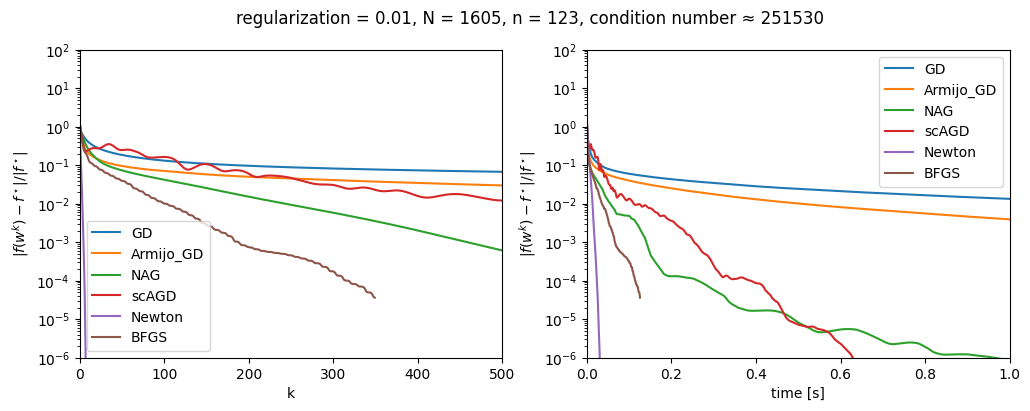

In [60]:
test_dataset_BFGS("a1a", 0.01, compare_to_previous=True)

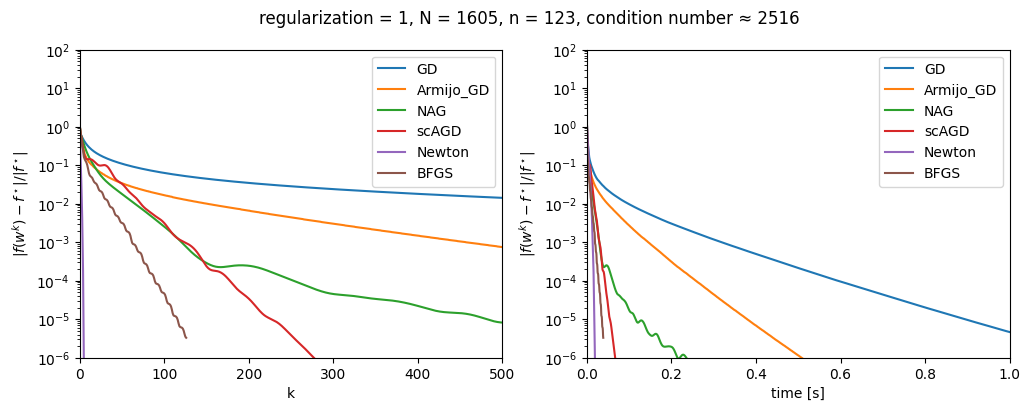

In [61]:
test_dataset_BFGS("a1a", 1, compare_to_previous=True)

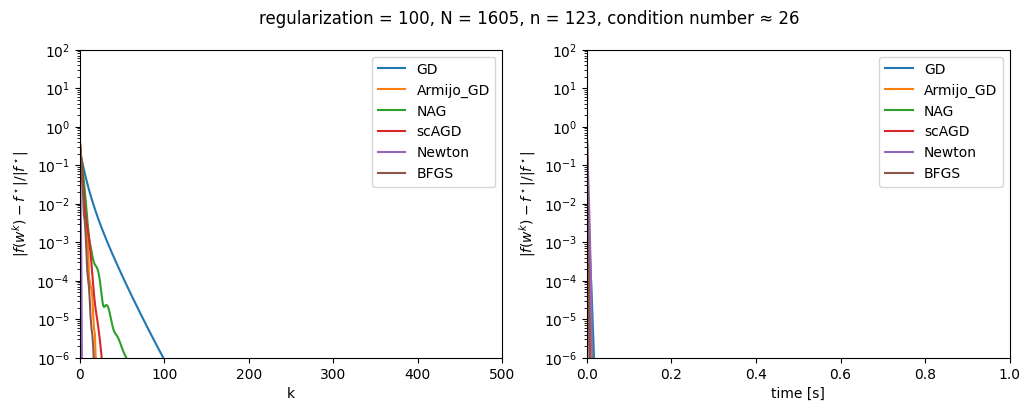

In [52]:
test_dataset_BFGS("a1a", 100, compare_to_previous=True)

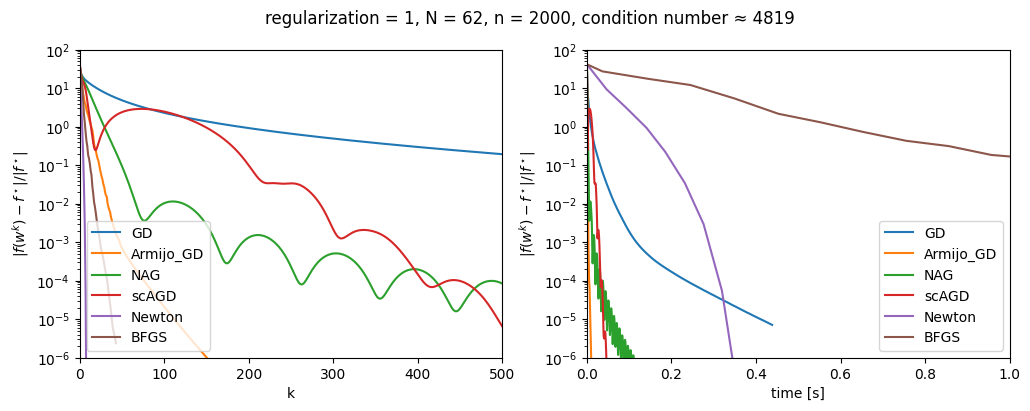

In [53]:
test_dataset_BFGS("colon", 1)

The current implementation of BFGS does not ensure that $H_k$ remains positive definite. One way to ensure that $H_k$ remains positive definite is by ensuring that the step size $\eta_k$ satisfies the Wolfe conditions ($0 < \sigma < \zeta < 1$)

\begin{align*}
    f(w^k + \eta_k d^k) {}\leq{}& f(w^k) + \eta_k \sigma \nabla f(w^k)^\top d^k\\
    \nabla f(w^k + \eta_k d^k)^\top d^k {}\geq{}& \zeta \nabla f(w^k)^\top d^k
\end{align*}
Common choices are $\sigma = 10^{-4}$, $\eta_k = 0.1$. To ensure that these conditions hold, one can employ the so-called bisection method, which is given as follows.

---

**Bisection method for Wolfe conditions**<br>
**Input:** $0<\sigma<\zeta<1$, $\underline{\eta}=0$, $\overline{\eta}=+\infty$, $\eta_{init}=1$ <br>
1. $\eta_k \leftarrow \eta_{init}$
2. **while** $k < $ max_iter **do** <br>
    $w_{trial} = w_k + \eta_k d_k$ <br>
    **if** $f(w^k + \eta d^k) > f(w^k) + \eta \sigma \nabla f(w^k)^\top d^k$ **do**<br>
    &emsp;$\overline{\eta} \leftarrow \eta$&emsp;&emsp; (decrease step) <br>
    &emsp;$\eta_k \leftarrow \tfrac{1}{2}(\underline{\eta}+\overline{\eta})$<br>
    **else if** $\nabla f(w^k+\eta d^k)^\top d^k < \zeta\nabla f(w^k)^\top d^k$ **do**<br>
    &emsp;$\underline{\eta} \leftarrow \eta$&emsp;&emsp; (increase step) <br>
    &emsp;**if** $\overline{\eta} = +\infty$ **do**<br>
    &emsp;&emsp;$\eta_k \leftarrow 2\underline{\eta}$<br>
    &emsp;**else**<br>
    &emsp;&emsp;$\eta_k \leftarrow \tfrac{1}{2}(\underline{\eta}+\overline{\eta})$<br>
3. **Return** $w_{trial}$

---

**Task 6c**: Update your implementation of BFGS from task 5a, using the bisection method instead of the Armijo linesearch.

In [1]:
def bisection_method(f, grad, search_direction : np.ndarray, w0 : np.ndarray, fw0 : float, directional_derivative_w0 : float, sigma: float, eta: float):
    max_iter = 1000
    eta = 1
    eta_l = 0
    eta_u = np.inf

    trial_w = w0
    for iter in range(max_iter):

        ##################################################
        ### TODO: Write your code here
        ##################################################

        trial_w = None
        
        ##################################################

        trial_w = w0 + eta * search_direction
        if f(trial_w) > fw0 + eta * sigma * directional_derivative_w0:
            eta_u = eta
            eta = (1/2) * (eta_l + eta_u)
        elif grad(trial_w).T @ search_direction < eta * directional_derivative_w0:
            eta_l = eta
            if eta_u == np.inf:
                eta = 2 * eta_l
            else:
                eta = (1/2) * (eta_l + eta_u)
        else:
            break

    return trial_w

NameError: name 'np' is not defined

In [ ]:
def BFGS(f, grad, w0 : np.ndarray, tolerance : float, max_iter : int, print = True):
    w = w0
    
    # Evaluate f and gradient
    fw= f(w)
    gradw = grad(w)
    norm_gradw = np.linalg.norm(gradw)

    # Initialize BFGS matrix
    H = np.eye(w0.shape[0])

    # Create dictionary for storing history
    hist = {'w':[w],'f':[fw], 'norm_grad':[norm_gradw], 'time':[0]}
    tic = time.perf_counter()

    for iter in range(max_iter):
        w_prev = w
        gradw_prev = gradw

        ##################################################
        ### TODO: Write your code here
        ##################################################

        # Find search direction and perform step using Armijo
        search_direction = np.linalg.solve(H, -gradw)
        directional_derivative = gradw.T @ search_direction
        w = bisection_method(f, search_direction, w, fw, directional_derivative, 1, 0.6, 1e-1)
        
        # Evaluate f, gradient and gradient norm
        fw = f(w)
        gradw = grad(w)
        norm_gradw = np.linalg.norm(gradw)

        ##################################################

        # Update history
        toc = time.perf_counter()
        hist['w'].append(w)
        hist['f'].append(fw)
        hist['norm_grad'].append(norm_gradw)
        hist['time'].append(toc-tic)

        # Stopping criterion
        if norm_gradw <= tolerance:
            break
        
        ##################################################
        ### TODO: Write your code here
        ##################################################

        # Update BFGS matrix
        s = np.reshape(w - w_prev, (-1, 1))
        p = np.reshape(gradw - gradw_prev, (-1, 1))
        H = H + p @ p.T / (p.T @ s) - H @ s @ s.T @ H / (s.T @ H @ s)

        ##################################################

    if print:
        print_info(w, iter, max_iter)

    hist['w'] = np.array(hist['w'])
    return hist

In [ ]:
test_dataset_BFGS("a1a", 0.01)

In [ ]:
test_dataset_BFGS("a1a", 1)

In [ ]:
test_dataset_BFGS("a1a", 100)